<a href="https://colab.research.google.com/github/nileshmalode11/taxi_time_duration_2023_dataset/blob/main/NYCTaxiDurationPrediction_17Jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# Data working packages
import numpy as np
import pandas as pd
#import pandas_profiling as pdp
import math

# Feature engineering packages
from geopy import distance
from datetime import datetime

# Graph packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Building model and normalization packages
import lightgbm as lgb


In [ ]:
pip install klib

In [ ]:
import klib

In [ ]:
df_taxi = pd.read_parquet('/content/drive/MyDrive/nyc_taxi_trip/yellow_tripdata_2022-02.parquet', engine='pyarrow')
df_taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.0,5.40,1.0,N,138,252,1,17.0,1.75,0.5,3.90,0.00,0.3,23.45,0.0,1.25
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.0,6.40,1.0,N,138,41,2,21.0,1.75,0.5,0.00,6.55,0.3,30.10,0.0,1.25
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.0,12.50,1.0,N,138,200,2,35.5,1.75,0.5,0.00,6.55,0.3,44.60,0.0,1.25
3,2,2022-02-01 00:08:00,2022-02-01 00:28:05,1.0,9.88,1.0,N,239,200,2,28.0,0.50,0.5,0.00,3.00,0.3,34.80,2.5,0.00
4,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.0,12.16,1.0,N,138,125,1,35.5,0.50,0.5,8.11,0.00,0.3,48.66,2.5,1.25


In [ ]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979431 entries, 0 to 2979430
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [ ]:
df_taxi.isnull().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          101738
trip_distance                 0
RatecodeID               101738
store_and_fwd_flag       101738
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     101738
airport_fee              101738
dtype: int64

In [ ]:
df_taxi.dropna(inplace=True)

In [ ]:
df_taxi.store_and_fwd_flag.value_counts()

N    2819642
Y      58051
Name: store_and_fwd_flag, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df_taxi['store_and_fwd_flag'] = label_encoder.fit_transform(df_taxi['store_and_fwd_flag'])

In [ ]:
df_taxi['trip_duration'] = (df_taxi['tpep_dropoff_datetime'] - df_taxi['tpep_pickup_datetime']).dt.total_seconds()


In [ ]:
df_taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.0,5.40,1.0,0,138,252,1,17.0,1.75,0.5,3.90,0.00,0.3,23.45,0.0,1.25,746.0
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.0,6.40,1.0,0,138,41,2,21.0,1.75,0.5,0.00,6.55,0.3,30.10,0.0,1.25,1053.0
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.0,12.50,1.0,0,138,200,2,35.5,1.75,0.5,0.00,6.55,0.3,44.60,0.0,1.25,1419.0
3,2,2022-02-01 00:08:00,2022-02-01 00:28:05,1.0,9.88,1.0,0,239,200,2,28.0,0.50,0.5,0.00,3.00,0.3,34.80,2.5,0.00,1205.0
4,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.0,12.16,1.0,0,138,125,1,35.5,0.50,0.5,8.11,0.00,0.3,48.66,2.5,1.25,1579.0


In [ ]:
columns_to_drop = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
df_taxi = df_taxi.drop(columns=columns_to_drop)

In [ ]:
df_taxi['total_dist_coordinates'] = (df_taxi['PULocationID'] - df_taxi['DOLocationID']).abs()


Displaying positive correlations. Specify a positive "threshold" to limit the results further.
Displaying negative correlations. Specify a negative "threshold" to limit the results further.


<Axes: title={'center': 'Feature-correlation (pearson)'}>

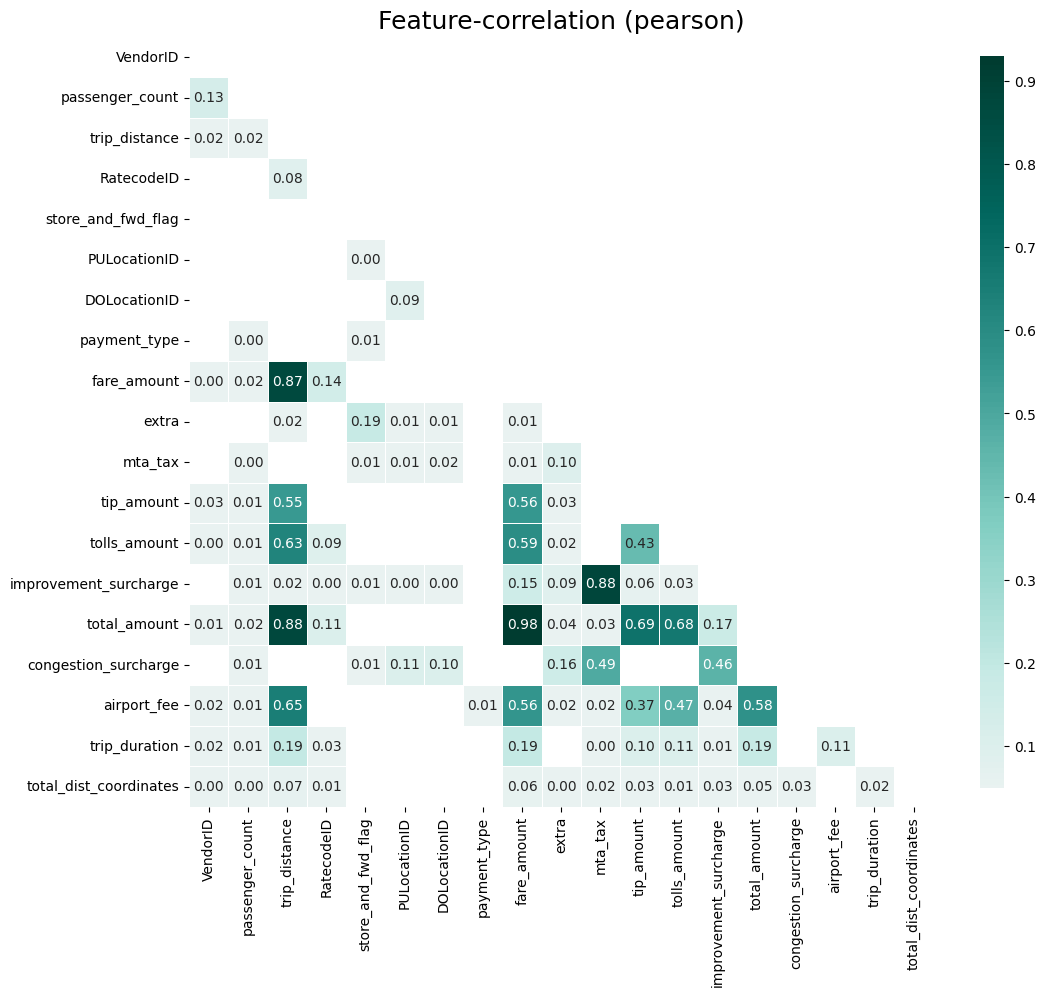

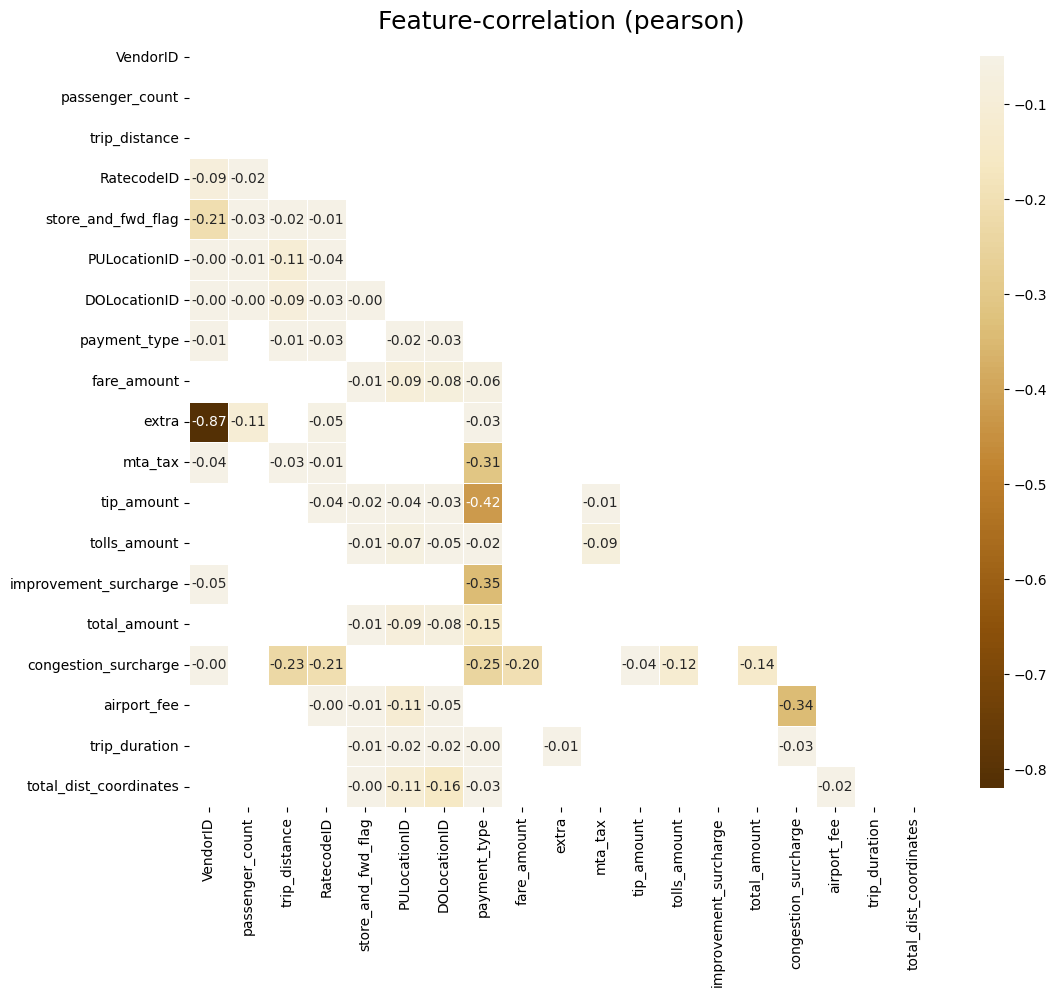

In [ ]:
klib.corr_plot(df_taxi, split='pos') # displaying only positive correlations, other settings include threshold, cmap...
klib.corr_plot(df_taxi, split='neg') # displaying only negative correlations

<Axes: title={'center': 'Feature-correlation (pearson)'}>

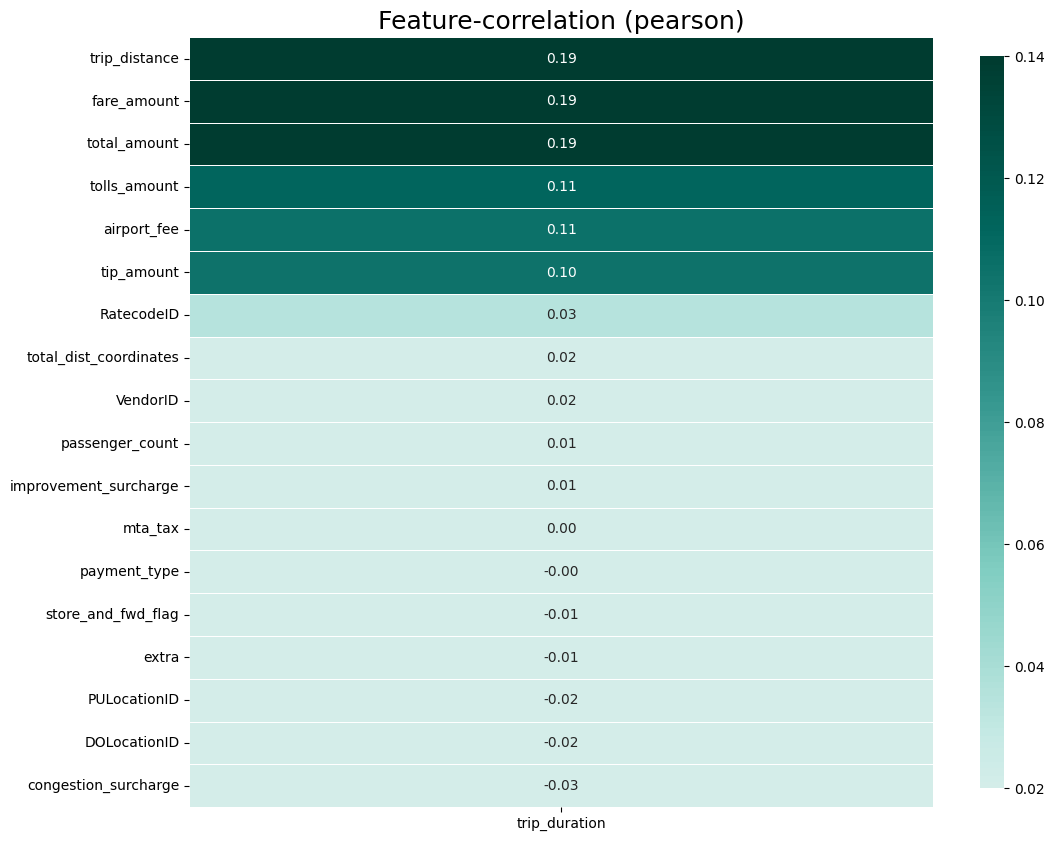

In [ ]:
klib.corr_plot(df_taxi, target='trip_duration') # default representation of correlations with the feature column


Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='passenger_count', ylabel='Density'>

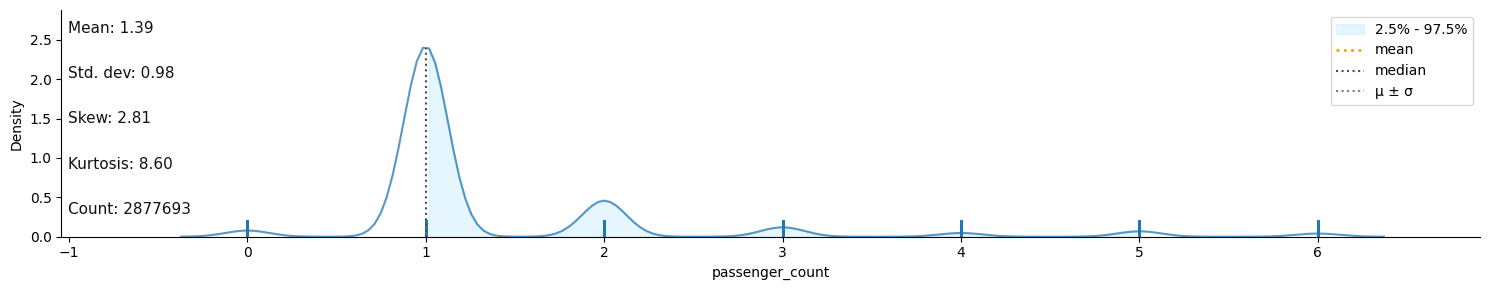

In [ ]:
klib.dist_plot(df_taxi) # default representation of a distribution plot, other settings include fill_range, histogram, ...


# Model Building

In [ ]:
X = df_taxi.drop('trip_duration',axis=1)
y = df_taxi['trip_duration']

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)


In [ ]:
X_train.shape


(2302154, 18)

In [ ]:
X_test.shape


(575539, 18)

In [ ]:
!pip install lightgbm


In [ ]:
import lightgbm as lgb


In [ ]:
# Define a dictionary of parameters for configuring the LightGBM regression model.
params = {
	'objective': 'regression',
	'metric': 'rmse',
	'boosting_type': 'gbdt',
	'num_leaves': 31,
	'learning_rate': 0.05,
	'feature_fraction': 0.9,
}


In [ ]:
# Create a LightGBM dataset for training with features X_train and labels Y_train
train_data = lgb.Dataset(X_train, label=y_train)

# Create a LightGBM dataset for testing with features X_val and labels Y_val,
# and specify the reference dataset as train_data for consistent evaluation
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


In [ ]:
# Set the number of rounds and train the model with early stopping
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[
				test_data])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1728
[LightGBM] [Info] Number of data points in the train set: 2302154, number of used features: 18
[LightGBM] [Info] Start training from score 934.736917


In [ ]:
# Import necessary libraries for calculating mean squared error and using the LightGBM regressor.
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor

# Create an instance of the LightGBM Regressor with the RMSE metric.
model = LGBMRegressor(metric='rmse')

# Train the model using the training data.
model.fit(X_train, y_train)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1728
[LightGBM] [Info] Number of data points in the train set: 2302154, number of used features: 18
[LightGBM] [Info] Start training from score 934.736917


LGBMRegressor(metric='rmse')

In [ ]:
# Make predictions on the training and validation data.
y_train_predictions = model.predict(X_train)
y_test_predictions = model.predict(X_test)


In [ ]:
# Calculate and print the Root Mean Squared Error (RMSE) for training and validation predictions.
print("Training RMSE: ", np.sqrt(mse(y_train_predictions, y_train)))
print("Validation RMSE: ", np.sqrt(mse(y_test_predictions, y_test)))


Training RMSE:  2781.1293710920704
Validation RMSE:  2779.8113559118146


# ANN

In [ ]:
X = df_taxi.drop('trip_duration',axis=1)
y = df_taxi['trip_duration']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam


In [ ]:
model = Sequential()

model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=10000,epochs=15)


Epoch 1/15
231/231 [==============================] - 8s 34ms/step - loss: 7824249.5000 - val_loss: 7728660.0000
Epoch 2/15
231/231 [==============================] - 8s 33ms/step - loss: 7822846.5000 - val_loss: 7728330.5000
Epoch 3/15
231/231 [==============================] - 8s 33ms/step - loss: 7822493.0000 - val_loss: 7727891.5000
Epoch 4/15
231/231 [==============================] - 8s 33ms/step - loss: 7822262.0000 - val_loss: 7727816.5000
Epoch 5/15
231/231 [==============================] - 8s 33ms/step - loss: 7821931.0000 - val_loss: 7727633.5000
Epoch 6/15
231/231 [==============================] - 8s 33ms/step - loss: 7821746.0000 - val_loss: 7727677.5000
Epoch 7/15
231/231 [==============================] - 8s 33ms/step - loss: 7821624.0000 - val_loss: 7727990.0000
Epoch 8/15
231/231 [==============================] - 8s 34ms/step - loss: 7821382.0000 - val_loss: 7727587.0000
Epoch 9/15
231/231 [==============================] - 8s 34ms/step - loss: 7821265.0000 - val_lo

In [ ]:
losses = pd.DataFrame(model.history.history)


<Axes: >

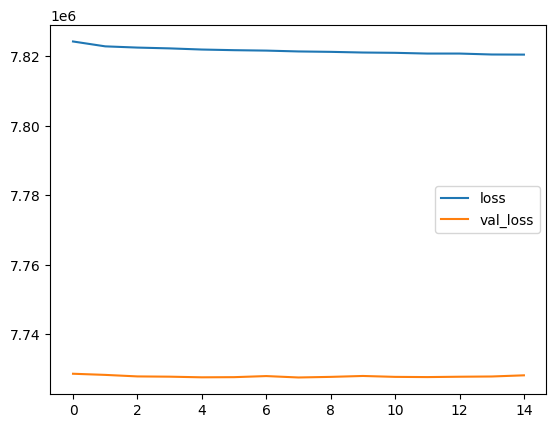

In [ ]:
losses.plot()


In [ ]:
# Evaluation on Test Data
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
predictions = model.predict(X_test)


17986/17986 [==============================] - 27s 1ms/step


In [ ]:
mean_absolute_error(y_test,predictions)



214.7374351306858

In [ ]:
np.sqrt(mean_squared_error(y_test,predictions))


2779.9677243232486

In [ ]:
explained_variance_score(y_test,predictions)


0.05581255445896882

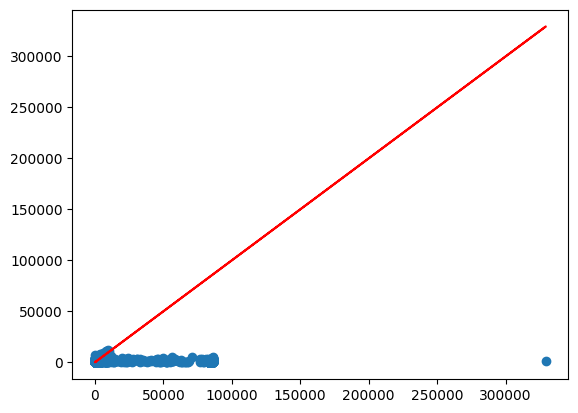

In [ ]:
# Our predictions
plt.scatter(y_test,predictions)

# Perfect predictions
plt.plot(y_test,y_test,'r')